# Bibliotecas

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
! pip install spacy==3.5
! pip install transformers
! python -m spacy download en_core_web_sm
import spacy
nlp = spacy.load("en_core_web_sm")
import json
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import collections
import tensorflow as tf
import transformers
import numpy as np
import pandas as pd
import gensim.downloader
from gensim.models import Word2Vec
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import svm
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 67.5 MB/s eta 0:00:00
  Attempting uninstall: spacy
    Found existing installation: spacy 3.5.2
    Uninstalling spacy-3.5.2:
      Successfully uninstalled spacy-3.5.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 87.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 89.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.4 MB/s eta 0:00:00
2023-05-01 10:09:25.145836: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-01 10:09:26.0979

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


# Coletando Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Lendo o arquivo csv
reviews_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NLP/Scraping reviews.csv', header=None)

# Renomeando as colunas
reviews_df = reviews_df.rename(columns={0: 'ID', 1: 'review', 2: 'rating'})

# Exibindo o dataframe resultante
print(reviews_df)


          ID                                             review  rating
0        NaN                                               text  rating
1        0.0  OK, I fouled up with my Kindle Paperwhite 11th...     4.0
2        1.0  The first thing I thought of when I saw an e-r...     4.0
3        2.0  I don't like upgrades. Every time I'm forced t...     4.0
4        3.0  PROS: Well, I REALLY like the 11th Gen over my...     4.0
...      ...                                                ...     ...
3345  3344.0  I love reading in bed before I go to sleep, I’...     5.0
3346  3345.0           Perfect replacement for an older Kindle.     5.0
3347  3346.0  I can't believe i waited so long to get one of...     5.0
3348  3347.0  If you love to read like myself I recommend yo...     5.0
3349  3348.0  Bought this to replace a stolen Kindle that wa...     5.0

[3350 rows x 3 columns]


In [ ]:
reviews_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3350 entries, 0 to 3349
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      3349 non-null   float64
 1   review  3345 non-null   object 
 2   rating  3350 non-null   object 
dtypes: float64(1), object(2)
memory usage: 78.6+ KB


In [ ]:
reviews_df = reviews_df.dropna(axis=0)
reviews_df['ID'] = reviews_df['ID'].astype(int)
reviews_df['rating'] = reviews_df['rating'].astype(float)
reviews_df = reviews_df.set_index('ID')

In [ ]:
reviews_df.sample(10)

,review,rating
ID,,
894,Great gift for an avid book reader. They love ...,3.0
814,i stopped reading for a while bc the only time...,4.0
2639,"I rarely write reviews. However this time, I w...",1.0
2985,I had a paperwhite from 2012. This is an incre...,5.0
1433,I am on my second kindle paper white. The firs...,4.0
2859,living in our RV whilst our house is being bui...,5.0
196,"I said I'd never stop reading paper books, but...",4.0
2880,"This could not be any better, it is the latest...",5.0
103,This kindle is perfect! I’ve been wanting to g...,5.0


# Pré-Processamento

##Configurar Targets

In [ ]:
reviews_df['Sentimento'] = reviews_df['rating'].apply(lambda x: 0 if x >= 4 else 1)

In [ ]:
reviews_df

,review,rating,Sentimento
ID,,,
0,"OK, I fouled up with my Kindle Paperwhite 11th...",4.0,0
1,The first thing I thought of when I saw an e-r...,4.0,0
2,I don't like upgrades. Every time I'm forced t...,4.0,0
3,"PROS: Well, I REALLY like the 11th Gen over my...",4.0,0
4,Kindle Signature Paperwhite plus Charging Stan...,4.0,0
...,...,...,...
3344,"I love reading in bed before I go to sleep, I’...",5.0,0
3345,Perfect replacement for an older Kindle.,5.0,0
3346,I can't believe i waited so long to get one of...,5.0,0


In [ ]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3344 entries, 0 to 3348
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   review      3344 non-null   object 
 1   rating      3344 non-null   float64
 2   Sentimento  3344 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 104.5+ KB


##Verificando o Balanceamento do Dataset

In [ ]:
# contando a quantidade de ocorrências de cada valor na coluna sentimento
counts = reviews_df['Sentimento'].value_counts()

In [ ]:
# contando a quantidade de ocorrências de cada valor na coluna sentimento
counts = reviews_df['Sentimento'].value_counts()

# imprimindo os resultados
print(f'Quantidade de Sentimentos Positivos: {counts[0]} - {round(counts[0]/(counts[0]+counts[1])*100,2)}%')
print(f'Quantidade de Sentimentos Negativos: {counts[1]} - {round(counts[1]/(counts[0]+counts[1])*100,2)}%')

Quantidade de Sentimentos Positivos: 2125 - 63.55%
Quantidade de Sentimentos Negativos: 1219 - 36.45%


##Separando dados de testes

In [ ]:
reviews_df, test_df = train_test_split(reviews_df, test_size=0.25, random_state=42)

In [ ]:
len(reviews_df)

2508

##Balanceando as Classes

In [ ]:
# separar os exemplos positivos e negativos
negativos = reviews_df[reviews_df['Sentimento'] == 1]
positivos = reviews_df[reviews_df['Sentimento'] == 0]

# reduzir a quantidade de exemplos positivos para o mesmo número de exemplos negativos
positivos_amostrados = positivos.sample(n=len(negativos), random_state=42)

# concatenar os exemplos positivos e negativos amostrados
df_amostrado = pd.concat([negativos, positivos_amostrados], axis=0)

# embaralhar as linhas do DataFrame resultante
df_amostrado = df_amostrado.sample(frac=1, random_state=42).reset_index(drop=True)


In [ ]:
counts = df_amostrado['Sentimento'].value_counts()
# imprimindo os resultados
print(f'Quantidade de Sentimentos Positivos: {counts[0]} - {round(counts[0]/(counts[0]+counts[1])*100,2)}%')
print(f'Quantidade de Sentimentos Negativos: {counts[1]} - {round(counts[1]/(counts[0]+counts[1])*100,2)}%')

Quantidade de Sentimentos Positivos: 933 - 50.0%
Quantidade de Sentimentos Negativos: 933 - 50.0%


#BOW

##Lemmatização

###Proposta A

In [ ]:
# Define uma função para lematizar um texto com o modelo de linguagem do Spacy
def lematizar_texto(texto):
    doc = nlp(texto)
    tokens_lematizados = [token.lemma_ for token in doc]
    return ' '.join(tokens_lematizados)

# Aplica a função de lematização na coluna "review" do dataframe
df_amostrado['texto_lematizado_A'] = df_amostrado['review'].apply(lematizar_texto)
reviews_df['texto_lematizado_A'] = reviews_df['review'].apply(lematizar_texto)

In [ ]:
# Concatena todas as strings da coluna "texto_lematizado" em um único texto
texto_concatenado_amostrado = ' '.join(df_amostrado['texto_lematizado_A'].tolist())
texto_concatenado = ' '.join(reviews_df['texto_lematizado_A'].tolist())

# Divide o texto em tokens
tokens_amostrado = texto_concatenado_amostrado.split()
tokens = texto_concatenado.split()


# Conta o número de tokens únicos
num_tokens_unicos_amostrado = len(set(tokens_amostrado))
num_tokens_unicos = len(set(tokens))
print(f'O corpus lematizado amostrado tem {num_tokens_unicos_amostrado} tokens únicos.\nO corpus lematizado tem {num_tokens_unicos} tokens únicos.')

# Conta a frequência dos tokens
contagem_tokens_amostrados = collections.Counter(tokens_amostrado)
contagem_tokens = collections.Counter(tokens)

# Imprime os 10 tokens mais frequentes
print("Os 10 tokens amostrados mais frequentes são:")
for token, frequencia in contagem_tokens_amostrados.most_common(10):
    print(token, "-", frequencia)

print("Os 10 tokens mais frequentes são:")
for token, frequencia in contagem_tokens.most_common(10):
    print(token, "-", frequencia)

O corpus lematizado amostrado tem 3269 tokens únicos.
O corpus lematizado tem 4123 tokens únicos.
Os 10 tokens amostrados mais frequentes são:
. - 2884
I - 2278
the - 2172
be - 1975
to - 1458
it - 1308
, - 1298
and - 1242
a - 1142
not - 764
Os 10 tokens mais frequentes são:
. - 4223
I - 3465
the - 3344
be - 2987
to - 2163
, - 2023
it - 1951
and - 1860
a - 1699
not - 1095


In [ ]:
# Define as stopwords em inglês do nltk
stopwords_nltk = set(stopwords.words('english'))

# Define a pontuação a ser removida
pontuacao = set(string.punctuation)

# Define uma função para remover stopwords e pontuação de um texto
def remover_stopwords_pontuacao(texto):
    doc = nlp(texto)
    tokens_lematizados = [token.lemma_ for token in doc if token.text.lower() not in stopwords_nltk and token.text not in pontuacao]
    return ' '.join(tokens_lematizados)

# Aplica a função de remoção de stopwords e pontuação na coluna "texto_lematizado" do dataframe
df_amostrado['texto_limpo_A'] = df_amostrado['texto_lematizado_A'].apply(remover_stopwords_pontuacao)
reviews_df['texto_limpo_A'] = reviews_df['texto_lematizado_A'].apply(remover_stopwords_pontuacao)

In [ ]:
# Concatena todas as strings da coluna "texto_lematizado" em um único texto
texto_concatenado_amostrado = ' '.join(df_amostrado['texto_limpo_A'].tolist())
texto_concatenado = ' '.join(reviews_df['texto_limpo_A'].tolist())

# Divide o texto em tokens
tokens_amostrado = texto_concatenado_amostrado.split()
tokens = texto_concatenado.split()

# Conta o número de tokens únicos
num_tokens_unicos_amostrado = len(set(tokens_amostrado))
num_tokens_unicos = len(set(tokens))
print(f'O corpus lematizado amostrado tem {num_tokens_unicos_amostrado} tokens únicos.\nO corpus lematizado tem {num_tokens_unicos} tokens únicos.')

# Conta a frequência dos tokens
contagem_tokens_amostrados = collections.Counter(tokens_amostrado)
contagem_tokens = collections.Counter(tokens)

# Imprime os 10 tokens mais frequentes
print("Os 10 tokens amostrados mais frequentes são:")
for token, frequencia in contagem_tokens_amostrados.most_common(10):
    print(token, "-", frequencia)

print("Os 10 tokens mais frequentes são:")
for token, frequencia in contagem_tokens.most_common(10):
    print(token, "-", frequencia)

O corpus lematizado amostrado tem 3089 tokens únicos.
O corpus lematizado tem 3921 tokens únicos.
Os 10 tokens amostrados mais frequentes são:
Kindle - 394
read - 380
book - 365
kindle - 292
one - 286
screen - 278
get - 262
use - 250
new - 214
love - 203
Os 10 tokens mais frequentes são:
read - 639
Kindle - 611
book - 560
one - 448
kindle - 423
screen - 405
use - 377
get - 371
like - 352
love - 335


## Vetorização

###Proposta A

In [ ]:
vectorizer_amostrado = CountVectorizer()
vectorizer = CountVectorizer()
vectorizer_amostrado.fit_transform(df_amostrado['texto_limpo_A'])
vectorizer.fit_transform(reviews_df['review'])

<836x4623 sparse matrix of type '<class 'numpy.int64'>'
	with 42973 stored elements in Compressed Sparse Row format>

##Pipeline

In [ ]:
def pipeline (df, coluna, vectorizer=vectorizer):
  df['texto_lematizado_A'] = df['review'].apply(lematizar_texto)
  df['texto_limpo_A'] = df['texto_lematizado_A'].apply(remover_stopwords_pontuacao)
  X = test_df[coluna].values
  y = test_df['Sentimento'].values
  y = np.array(y, dtype=np.int32)
  Encoder = LabelEncoder()
  y = Encoder.fit_transform(y)
  X = vectorizer.transform(X)
  return X, y


## Divisão de do Dataset em Treino e Teste

In [ ]:
#Train_X, Test_X, Train_Y, Test_Y = train_test_split(df_amostrado['texto_limpo_A'], df_amostrado['Sentimento'], test_size=0.25)


In [ ]:
#Categorizando os Targets
def data_pre_processing (X_train,X_test,y_train,y_test):
  Encoder = LabelEncoder()
  Train_Y = Encoder.fit_transform(y_train)
  Test_Y = Encoder.fit_transform(y_test)
  Train_X = vectorizer.transform(X_train)
  Test_X = vectorizer.transform(X_test)
  return Train_X, Test_X, Train_Y, Test_Y

#SVM + BOW

## Definição, treinamento e parametros

In [ ]:
df_bank = [df_amostrado,reviews_df]
colunas = ['texto_limpo_A','texto_lematizado_A', 'review']
accuracy = 0
f1_Score = 0

for df in df_bank:
  for coluna in colunas:
    # Preparar dados
    X = df[coluna].values
    y = df['Sentimento'].values
    y = np.array(y, dtype=np.int32)
    Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, y, test_size=0.25, random_state=42)
    Train_X_bow, Test_X_bow, Train_Y, Test_Y = data_pre_processing(Train_X, Test_X, Train_Y, Test_Y)
    #kernels = ['poly','linear', 'sigmoid', 'rbf']
    kernels = ['linear','sigmoid', 'rbf']
    #C = [27]
    C = [15,20,25,30]
    degree = [2, 3 , 4]
    d = 0
    for kernel in kernels:
      for c in C:
        if kernel == 'poly':
          for d in degree:
            SVM = svm.SVC(C=c, kernel=kernel, degree=d, gamma='auto')
            SVM.fit(Train_X_bow,Train_Y)
            predictions_SVM = SVM.predict(Test_X_bow)
            accuracy_tes = accuracy_score(predictions_SVM, Test_Y)*100
            f1_Score_tes = f1_score(predictions_SVM, Test_Y)*100
            if f1_Score_tes > f1_Score:
              accuracy = accuracy_tes
              f1_Score = f1_Score_tes
              kernel_best = kernel
              C_best = c
              d_best = d
        else:
            SVM = svm.SVC(C=c, kernel=kernel, gamma='auto')
            SVM.fit(Train_X_bow,Train_Y)
            X,y = pipeline(test_df, coluna)
            y_pred = SVM.predict(X)
            accuracy_tes = accuracy_score(y_pred , y)*100
            f1_Score_tes = f1_score(y_pred , y)*100
            if f1_Score_tes > f1_Score:
              accuracy = accuracy_tes
              f1_Score = f1_Score_tes
              kernel_best = kernel
              C_best = c
              d_best = d
              best_df_svm_bow = df
              best_coluna_svm_bow = coluna
              best_predict = y_pred
print(f'Melhor Coluna: {best_coluna_svm_bow}\nMelhor Kernel: {kernel_best}\nMelhor C: {C_best}\nSVM Accuracy Score -> {accuracy}\nSVM F1 Score -> {f1_Score}')

Melhor Coluna: review
Melhor Kernel: linear
Melhor C: 15
SVM Accuracy Score -> 88.43537414965986
SVM F1 Score -> 88.38268792710706


##Resultados

In [ ]:
svm_bow_acu = accuracy
svm_bow_f1 = f1_Score
print(f'SVM Accuracy Score -> {accuracy}\nSVM F1 Score -> {f1_Score}')

SVM Accuracy Score -> 88.43537414965986
SVM F1 Score -> 88.38268792710706


## Inspecionando os Resultados

In [ ]:
# Encontra os índices dos 10 primeiras avaliações negativas
n= 10
indices = [i for i in range(len(best_predict)) if best_predict[i] == 1][:n]
df = test_df.reset_index(drop=True)
print(f'As {n} primeiras avaliações que o modelo considerou como negativas:\n\n')
for i in indices:
  print(f'{i} Avaliação: {df.iloc[i]}\n')

As 10 primeiras avaliações que o modelo considerou como negativas:


1 Avaliação: review                My kindle would not turn on after 2 weeks of u...
rating                                                              2.0
Sentimento                                                            1
texto_lematizado_A    my kindle would not turn on after 2 week of us...
texto_limpo_A         kindle would turn 2 week use tech could fix se...
Name: 1, dtype: object

3 Avaliação: review                La mejor opción para leer... ademas de toda la...
rating                                                              2.0
Sentimento                                                            1
texto_lematizado_A    La mejor opción para leer ... ademas de toda l...
texto_limpo_A         La mejor opción para leer ... ademas de toda l...
Name: 3, dtype: object

4 Avaliação: review                I am goi to LOVE my Kindle Paperwhite e-reader...
rating                                              

#Embedding

In [ ]:
# Pré-processamento textual antes de treinar o modelo Word2Vec

# tokenizador de sentença do nltk

tokenized_sents = [word_tokenize(i) for i in df_amostrado['review'].values]

In [ ]:
vector_size=50
model_review = Word2Vec(tokenized_sents, vector_size=vector_size, window=5, min_count=1, workers=4)

In [ ]:
Train_X, Test_X, Train_Y, Test_Y  = train_test_split(df_amostrado['review'],df_amostrado['Sentimento'],test_size=0.25)

In [ ]:
# Verificando o tamanho máximo do texto não estruturado (review)
Train_X_emb = []
max_len = 0

for i, row in Train_X.to_frame().iterrows():
  vetores = model_review.wv[word_tokenize(row['review'])]
  max_len = max(max_len, len(vetores))
  Train_X_emb.append(vetores)

Test_X_emb = []
for i, row in Test_X.to_frame().iterrows():
  vetores = model_review.wv[word_tokenize(row['review'])]
  max_len = max(max_len, len(vetores))
  Test_X_emb.append(vetores)

print("max_len: {}".format(max_len))

max_len: 2219


In [ ]:
#Categorizando os Targets
Train_Y = np.array(Train_Y).astype("float32")
Test_Y = np.array(Test_Y).astype("float32")
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.fit_transform(Test_Y)

In [ ]:
# Devemos utilizar um padding para padronizar o tamanho das nossas reviews em max_len.
# Isso é necessário para fazer o treino da rede neural

def transform(exemplos, dimension):
  results = np.zeros((len(exemplos), dimension, vector_size))
  for i, sequence in enumerate(exemplos):
    results[i, :len(sequence), :] = sequence
  return results
 
Train_X_emb = transform(Train_X_emb, max_len)
Test_X_emb = transform(Test_X_emb, max_len)

In [ ]:
print(f'Shape dados de Treino: {Train_X_emb.shape}\nShape Target de Treino: {Train_Y.shape}\nShape dados de Teste: {Test_X_emb.shape}\nShape Target de Teste: {Test_Y.shape}')

Shape dados de Treino: (627, 2219, 50)
Shape Target de Treino: (627,)
Shape dados de Teste: (209, 2219, 50)
Shape Target de Teste: (209,)


In [ ]:
def pipeline_emb(df,max_len=max_len):
  tokenized_sents = [word_tokenize(i) for i in df["review"].values]
  vector_size=50
  model_review = Word2Vec(tokenized_sents, vector_size=vector_size, window=5, min_count=1, workers=4) 
  X = df["review"]
  y = df["Sentimento"].values
  y = np.array(y).astype("float32")
  Encoder = LabelEncoder()
  y = Encoder.fit_transform(y)
  Train_X_emb = []
  max_len = 0 
  for i, row in X.to_frame().iterrows():
    vetores = model_review.wv[word_tokenize(row["review"])]
    max_len = max(max_len, len(vetores))
    Train_X_emb.append(vetores)
    X = transform(Train_X_emb, max_len)
    X = X.reshape(X.shape[0], -1)
  return X, y
  X_test, y_test = pipeline_emb(test_df,max_len=max_len)

# SVM + EMBEDDING

## Definição, treinamento e parametros

In [ ]:
# Criar modelo SVM
kernels = ['poly', 'linear', 'sigmoid', 'rbf']
C = [10, 30, 50, 70]
degree = [2, 3 , 4, 5]
accuracy = 0
f1_Score = 0
Train_X_emb = Train_X_emb.reshape(Train_X_emb.shape[0], -1)
Test_X_emb = Test_X_emb.reshape(Test_X_emb.shape[0], -1)
for kernel in kernels:
 for c in C:
   if kernel == 'poly':
    for d in degree:
      SVM = svm.SVC(C=c, kernel=kernel, degree=d, gamma='auto')
      SVM.fit(Train_X_emb, Train_Y)
      y_pred = SVM.predict(X_test)
      accuracy_tes = accuracy_score(y_pred , y_test)*100
      f1_Score_tes = f1_score(y_pred , y_test)*100
      if f1_Score_tes > f1_Score:
        accuracy = accuracy_tes
        f1_Score = f1_Score_tes
        kernel_best = kernel
        C_best = c
        d_best = d
        best_predict = y_pred
   else:
      SVM = svm.SVC(C=c, kernel=kernel, gamma='auto')
      SVM.fit(Train_X_emb, Train_Y)
      y_pred = SVM.predict(X_test)
      accuracy_tes = accuracy_score(y_pred , y_test)*100
      f1_Score_tes = f1_score(y_pred , y_test)*100
      if f1_Score_tes > f1_Score:
        accuracy = accuracy_tes
        f1_Score = f1_Score_tes
        kernel_best = kernel
        C_best = c
        d_best = d
        best_predict = y_pred
print(f'Melhor Kernel: {kernel_best}\nMelhor C: {C_best}\nSVM Accuracy Score -> {accuracy}\nSVM F1 Score -> {f1_Score}')

Melhor Kernel: linear
Melhor C: 10
SVM Accuracy Score -> 78.2312925170068
SVM F1 Score -> 80.95238095238096


##Resultados

In [ ]:
svm_emb_acu = accuracy
svm_emn_f1 = f1_Score
print(f'SVM Accuracy Score -> {accuracy}\nSVM F1 Score -> {f1_Score}')

SVM Accuracy Score -> 78.2312925170068
SVM F1 Score -> 80.95238095238096


## Inspecionando os Resultados

In [ ]:
# Encontra os índices dos 10 primeiras avaliações negativas
n= 10
indices = [i for i in range(len(best_predict)) if best_predict[i] == 1][:n]
df = test_df.reset_index(drop=True)
print(f'As {n} primeiras avaliações que o modelo considerou como negativas:\n\n')
for i in indices:
  print(f'{i} Avaliação: {df.iloc[i]}\n')

As 10 primeiras avaliações que o modelo considerou como negativas:


1 Avaliação: review                My kindle would not turn on after 2 weeks of u...
rating                                                              2.0
Sentimento                                                            1
texto_lematizado_A    my kindle would not turn on after 2 week of us...
texto_limpo_A         kindle would turn 2 week use tech could fix se...
Name: 1, dtype: object

2 Avaliação: review                Reduced to one star for review manipulation by...
rating                                                              3.0
Sentimento                                                            1
texto_lematizado_A    reduce to one star for review manipulation by ...
texto_limpo_A         reduce one star review manipulation Amazon rea...
Name: 2, dtype: object

3 Avaliação: review                La mejor opción para leer... ademas de toda la...
rating                                              

#Resumo Resultado Final

In [14]:
bert_acu =  64.11483253588517
bert_f1 = 77.81065088757396

In [15]:
modelos = {'Modelo': ['Modelo SVM + BOW', 'Modelo SVM + EMBEDDING', 'BERT'],
        'Acurácia': [round(svm_bow_acu, 2), round(svm_emb_acu, 2), round(bert_acu, 2)],
        'F1-score': [round(svm_bow_f1, 2), round(svm_emb_f1, 2), round(bert_f1, 2)]}

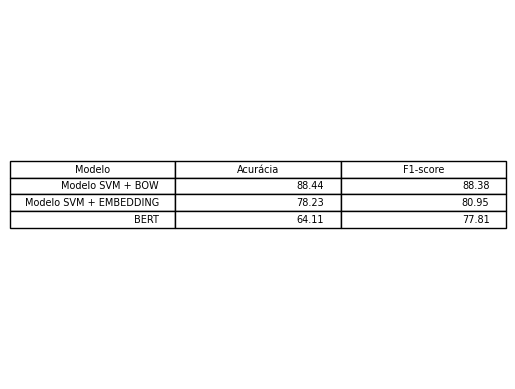

In [16]:
# Criar um dataframe com as informações dos modelos
df = pd.DataFrame(modelos)

# Criar uma tabela visual com as informações dos modelos
fig, ax = plt.subplots()
ax.axis('off')
ax.axis('tight')
ax.table(cellText=df.values, colLabels=df.columns, loc='center')
plt.show()